In [376]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn
import zipfile

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
ExpMat = pd.read_csv("dat/Jon_data/energy-exp_level.csv", index_col="ROW")
ExpMat2, ExpZscoreMat2, ExpMatNorm2, ExpZscoreMatNorm2 = LoadExpressionMatrices(
                        ExpMat = "../dat/allen-mouse-exp/new-energy-conn-model.csv", 
                        ExpZscoreMat = "../dat/allen-mouse-exp/new-energy-conn-zscore.csv",
                        ExpMatNorm = "../dat/allen-mouse-exp/energy-neuronorm.csv",
                        ExpZscoreMatNorm = "../dat/allen-mouse-exp/energy-zscore-neuronorm.csv")
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")
str2reg = STR2Region()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [507]:
# Load Mutations
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")

# FSIQ

In [331]:
IQ_dat = pd.read_excel("../doc/1-s2.0-S0092867419313984-mmc4.xlsx", sheet_name="Phenotype")
IQ_dat = IQ_dat.dropna(subset=['IQ'])

/Users/jiayao/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [332]:
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")

In [333]:
HighIQ = IQ_dat[IQ_dat["IQ"]>70]["Phenotype_ID"].values
LowIQ = IQ_dat[IQ_dat["IQ"]<=70]["Phenotype_ID"].values
print(len(HighIQ), len(LowIQ))

3292 1572


<AxesSubplot:>

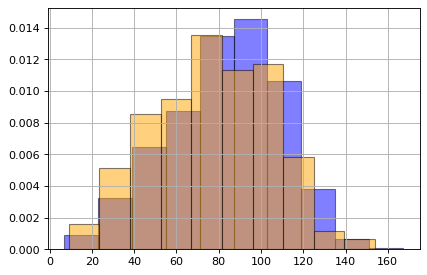

In [334]:
IQ_dat[IQ_dat["Sex"]=="Male"]["IQ"].hist(color="blue", density=1, alpha=0.5, edgecolor='black')
IQ_dat[IQ_dat["Sex"]=="Female"]["IQ"].hist(color="orange", density=1, alpha=0.5, edgecolor='black')

In [335]:
HighIQ = IQ_dat[(IQ_dat["IQ"]>70)]
LowIQ = IQ_dat[(IQ_dat["IQ"]<=70)]
MaleIQ = IQ_dat[IQ_dat["Sex"]=="Male"]
FemaleIQ = IQ_dat[IQ_dat["Sex"]=="Female"]
HighIQ_male = IQ_dat[(IQ_dat["IQ"]>70) & (IQ_dat["Sex"]=="Male")]
HighIQ_female = IQ_dat[(IQ_dat["IQ"]>70) & (IQ_dat["Sex"]=="Female")]
LowIQ_male = IQ_dat[(IQ_dat["IQ"]<=70) & (IQ_dat["Sex"]=="Male")]
LowIQ_female = IQ_dat[(IQ_dat["IQ"]<=70) & (IQ_dat["Sex"]=="Female")]

In [371]:
# Select HC genes
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
#Spark_Meta = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-3]
HighConfGenes = Spark_Meta_HC["HGNC"].values
HighConfMuts = ASD_Discov_Muts[ASD_Discov_Muts["HGNC"].isin(HighConfGenes)]
#HighConfMuts = ASD_Discov_Muts
HighConfMuts = Filt_LGD_Mis(HighConfMuts, Dmis=True)
#HighConfMuts = HighConfMuts[HighConfMuts["GeneEff"]!="missense"]

In [372]:
HIQ_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ["Phenotype_ID"].values)]
LIQ_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ["Phenotype_ID"].values)]

M_Muts = HighConfMuts[HighConfMuts["IID"].isin(MaleIQ["Phenotype_ID"].values)]
F_Muts = HighConfMuts[HighConfMuts["IID"].isin(FemaleIQ["Phenotype_ID"].values)]

HIQ_M_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ_male["Phenotype_ID"].values)]
HIQ_F_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighIQ_female["Phenotype_ID"].values)]
LIQ_M_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ_male["Phenotype_ID"].values)]
LIQ_F_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowIQ_female["Phenotype_ID"].values)]
print("HIQ_M: %d HIQ_F: %d LIQ_M: %d LIQ_F: %d"%
      (HIQ_M_Muts.shape[0], HIQ_F_Muts.shape[0], LIQ_M_Muts.shape[0], LIQ_F_Muts.shape[0]))

HIQ_M: 75 HIQ_F: 12 LIQ_M: 67 LIQ_F: 42


In [373]:
HIQ_Muts.to_csv("dat/Spark.ES.HIQ.muts.csv", index=False)
LIQ_Muts.to_csv("dat/Spark.ES.LIQ.muts.csv", index=False)

### Paired test on cortex vs. subcortex

In [457]:
IndvZ2 = pd.read_csv("dat/bias2/Indv.gene.z2.csv", index_col=0)
Circuit_STRs = pd.read_csv("dat/bias2/ASD.EW.pLI.Spec.bias.csv").head(50)["STR"].values
len(Circuit_STRs)

50

In [458]:
# make Group_Dictionary
REG2STRs = {}
Iso_Sub = {"Isocortex":[], "Subcortex":[]}
for STR in Circuit_STRs:
    reg = str2reg[STR]
    if reg not in REG2STRs:
        REG2STRs[reg] = []
    REG2STRs[reg].append(STR)
    if reg == "Isocortex":
        Iso_Sub["Isocortex"].append(STR)
    else:
        Iso_Sub["Subcortex"].append(STR)

In [459]:
#def GetExpBias(mat)

HIQ
Cortex 0.148	Subcortex: 0.331	WilcoxonP=8.330e-03

LIQ
Cortex 0.443	Subcortex: 0.433	WilcoxonP=7.396e-01

Male
Cortex 0.330	Subcortex: 0.416	WilcoxonP=1.528e-01

Female
Cortex 0.286	Subcortex: 0.326	WilcoxonP=6.169e-01

HIQ_Male
Cortex 0.189	Subcortex: 0.339	WilcoxonP=5.405e-02

HIQ_Female
Cortex -0.099	Subcortex: 0.282	WilcoxonP=1.855e-02

LIQ_Male
Cortex 0.481	Subcortex: 0.499	WilcoxonP=9.857e-01

LIQ_Female
Cortex 0.387	Subcortex: 0.337	WilcoxonP=5.951e-01



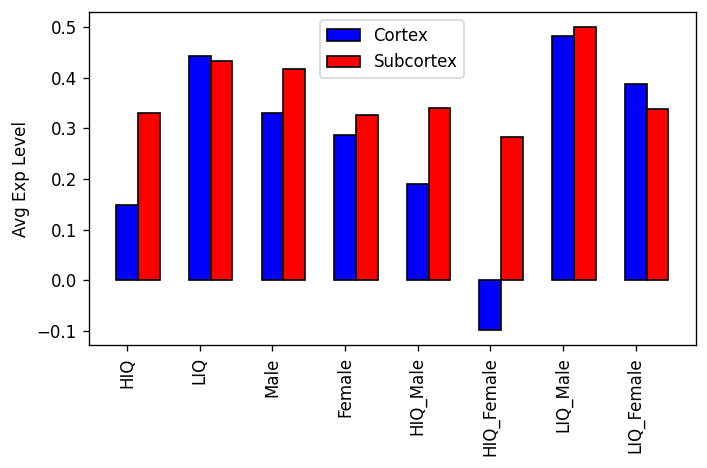

In [460]:
fig, ax = plt.subplots(dpi=120)
pos = 0
barWidth = 0.3
Cortex_dat = []
Subcortex_dat = []
for cohort, DF in zip(["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"], 
        [HIQ_Muts, LIQ_Muts, M_Muts, F_Muts, HIQ_M_Muts, HIQ_F_Muts, LIQ_M_Muts, LIQ_F_Muts]):
    X, Y = [], []
    for i, mut in DF.iterrows():
        try:
            x = IndvZ2.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Isocortex"])].values
            y = IndvZ2.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Subcortex"])].values
            x = np.mean([_ for _ in x if _==_])
            y = np.mean([_ for _ in y if _==_])
            X.append(x)
            Y.append(y)
        except:
            continue
    print(cohort)
    stat, p = scipy.stats.wilcoxon(X,Y)
    print("Cortex %.3f\tSubcortex: %.3f\tWilcoxonP=%.3e"%(np.mean(X), np.mean(Y), p))
    print()
    Cortex_dat.append(np.mean(X))
    Subcortex_dat.append(np.mean(Y))
    pos += 1
r1 = np.arange(pos)
r2 = [x + barWidth for x in r1]
plt.bar(r1, Cortex_dat, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Cortex')
plt.bar(r2, Subcortex_dat, width = barWidth, color = 'red', edgecolor = 'black', capsize=7, label='Subcortex')  
plt.xticks(list(range(pos)), 
           ["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"],
          rotation=90)
plt.ylabel('Avg Exp Level')
plt.legend()
plt.tight_layout()

#### ExpLevel

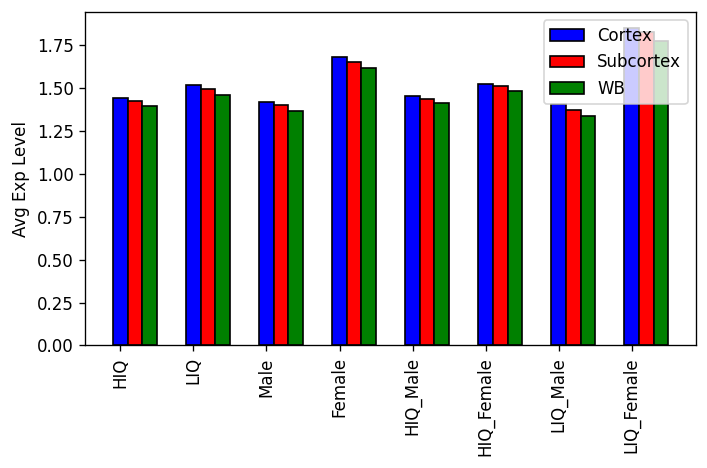

In [364]:
fig, ax = plt.subplots(dpi=120)
pos = 0
barWidth = 0.2
Cortex_dat = []
Subcortex_dat = []
WholeBrain_dat = []
for cohort, DF in zip(["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"], 
        [HIQ_Muts, LIQ_Muts, M_Muts, F_Muts, HIQ_M_Muts, HIQ_F_Muts, LIQ_M_Muts, LIQ_F_Muts]):
    X, Y, Z = [], [], []
    gene_already_showed = set([])
    for i, mut in DF.iterrows():
        try:
            if GeneSymbol2Entrez[mut["HGNC"]] in gene_already_showed:
                continue
            x = ExpMat.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Isocortex"])].values
            y = ExpMat.loc[GeneSymbol2Entrez[mut["HGNC"]], np.array(Iso_Sub["Subcortex"])].values
            z = ExpMat.loc[GeneSymbol2Entrez[mut["HGNC"]], :].values
            x = np.mean([_ for _ in x if _==_])
            y = np.mean([_ for _ in y if _==_])
            z = np.mean([_ for _ in z if _==_])
            X.append(x)
            Y.append(y)
            Z.append(z)
            gene_already_showed.add(GeneSymbol2Entrez[mut["HGNC"]])
        except:
            continue
    #print(cohort)
    stat, p = scipy.stats.wilcoxon(X,Y)
    #print("Cortex %.3f\tSubcortex: %.3f\tWilcoxonP=%.3e"%(np.mean(X), np.mean(Y), p))
    #plt.bar(pos-barWidth, np.mean(X), width=barWidth, color="blue", label="Cortex")
    #plt.bar(pos, np.mean(Y), width=barWidth, color="orange", label="Subcortex")
    Cortex_dat.append(np.mean(X))
    Subcortex_dat.append(np.mean(Y))
    WholeBrain_dat.append(np.mean(Z))
    pos += 1
    #print()
r1 = np.arange(pos)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.bar(r1, Cortex_dat, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Cortex')
plt.bar(r2, Subcortex_dat, width = barWidth, color = 'red', edgecolor = 'black', capsize=7, label='Subcortex')  
plt.bar(r3, WholeBrain_dat, width = barWidth, color = 'green', edgecolor = 'black', capsize=7, label='WB')  
plt.xticks(list(range(pos)), 
           ["HIQ", "LIQ", "Male", "Female", "HIQ_Male", "HIQ_Female", "LIQ_Male", "LIQ_Female"],
          rotation=90)
plt.ylabel('Avg Exp Level')
plt.legend()
plt.tight_layout()
plt.savefig("figs/IQ_Sex_ExpLevel.gene.pdf")

In [366]:
WholeBrain_dat

[1.3981411414499558,
 1.46207408528773,
 1.3691164748505738,
 1.6159985461036568,
 1.4106885763188395,
 1.4830206711443659,
 1.3349758569739083,
 1.7746308569632385]

(array([1572122.,  467007.,  313979.,  254840.,  218244.,  185358.,
         146492.,   93681.,   42355.,    6945.]),
 array([1.53646965e-04, 5.32952574e-01, 1.06575150e+00, 1.59855043e+00,
        2.13134936e+00, 2.66414828e+00, 3.19694721e+00, 3.72974614e+00,
        4.26254506e+00, 4.79534399e+00, 5.32814292e+00]),
 <BarContainer object of 10 artists>)

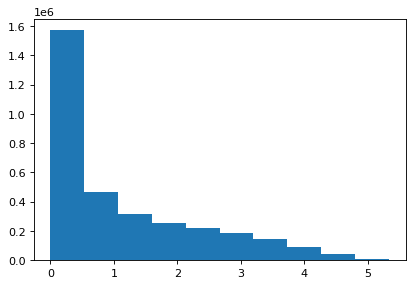

In [365]:
plt.hist(ExpMat.values.flatten())

###  Bias on sub-population

In [83]:
Agg_Match = pd.read_csv("dat/Final_Spark_Meta.Matches.csv", index_col="GENE")

In [84]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn
def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        pLI = float(row["ExACpLI"])
        Muts = MutDF[MutDF["HGNC"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        if pLI > 0.05:
            gene2MutN[Entrez] = N_LGD * 0.554 + N_Dmis * 0.333
        else:
            gene2MutN[Entrez] = N_LGD * 0.138 + N_Dmis * 0.130
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [ ]:
HIQ_GW = Mut2GeneDF(HIQ_Muts, 0.347, 0.194) # Not use weights input
HIQ_Spec = AvgSTRZ_Weighted(ExpZscoreMat, HIQ_GW, Match_DF=Agg_Match, 
                                 Method = 2, csv_fil = "dat/bias2/ASD.HIQ_spec.bias.csv")

LIQ_GW = Mut2GeneDF(LIQ_Muts, 0.347, 0.194)
LIQ_Spec = AvgSTRZ_Weighted(ExpZscoreMat, LIQ_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.LIQ_spec.bias.csv")


In [92]:

Male_GW = Mut2GeneDF(M_Muts, 0.347, 0.194)
Male_Spec = AvgSTRZ_Weighted(ExpZscoreMat, Male_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.Male_spec.bias.csv")

Female_GW = Mut2GeneDF(F_Muts, 0.347, 0.194)
Female_Spec = AvgSTRZ_Weighted(ExpZscoreMat, Female_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.Female_spec.bias.csv")

In [93]:
HIQ_M_GW = Mut2GeneDF(HIQ_M_Muts, 0.347, 0.194)
HIQ_M_Spec = AvgSTRZ_Weighted(ExpZscoreMat, HIQ_M_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.HIQ_M_spec.bias.csv")

HIQ_F_GW = Mut2GeneDF(HIQ_F_Muts, 0.347, 0.194)
HIQ_F_Spec = AvgSTRZ_Weighted(ExpZscoreMat, HIQ_F_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.HIQ_F_spec.bias.csv")

LIQ_M_GW = Mut2GeneDF(LIQ_M_Muts, 0.347, 0.194)
LIQ_M_Spec = AvgSTRZ_Weighted(ExpZscoreMat, LIQ_M_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.LIQ_M_spec.bias.csv")

LIQ_F_GW = Mut2GeneDF(LIQ_F_Muts, 0.347, 0.194)
LIQ_F_Spec = AvgSTRZ_Weighted(ExpZscoreMat, LIQ_F_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.LIQ_F_spec.bias.csv")

In [107]:
#HIQ_Spec = HIQ_Spec.set_index("STR")
#LIQ_Spec = LIQ_Spec.set_index("STR")
#Male_Spec = Male_Spec.set_index("STR")
#Female_Spec = Female_Spec.set_index("STR")

#HIQ_M_Spec = HIQ_M_Spec.set_index("STR")
#HIQ_F_Spec = HIQ_F_Spec.set_index("STR")
#LIQ_M_Spec = LIQ_M_Spec.set_index("STR")
#LIQ_F_Spec = LIQ_F_Spec.set_index("STR")

In [222]:
#Circuit_STRs = pd.read_csv("dat/Circuit_GN_42.csv")["STR"].values
Circuit_STRs = pd.read_csv("dat/bias2/ASD.EW.pLI.Spec.bias.csv").head(50)["STR"].values
len(Circuit_STRs)

50

In [223]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
     'Olfactory_areas']
Isocortex = ["Isocortex"]
Subcortex = ['Hippocampus', 'Cortical_subplate', 
     'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum', 'Olfactory_areas']

In [237]:
REG_Layer1 = {}
REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
REG_Layer2["Cortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
REG_Layer2["Subcortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in REG_Layer1:
        REG_Layer1[REG] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
    REG_Layer1[REG]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    REG_Layer2[Broder]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])
        

In [238]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("figs/PhenotypeBias.pdf")

In [239]:
data = []
for group in ["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(REG_Layer2[Broder][group]))
    data.append(tmp)
data = np.array(data)
data = data.transpose()

In [240]:
data.shape

(2, 4)

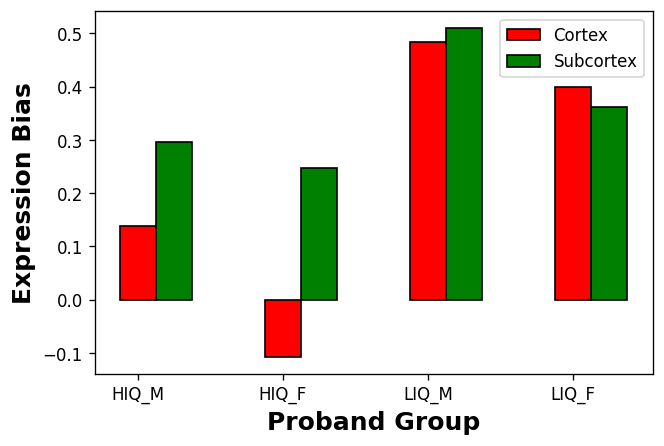

In [241]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(4)
ax.bar(X + 0.00, data[0], color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.25, data[1], color='green', width=0.25, label="Subcortex", edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['HIQ_M', 'HIQ_F', 'LIQ_M', 'LIQ_F'])
 
plt.legend()
pdf.savefig( fig )

In [242]:
# All Regions
Circuit_STRs = pd.read_csv("dat/bias2/ASD.EW.Spec.bias.csv").head(50)["STR"].values
len(Circuit_STRs)
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
     'Olfactory_areas']
Isocortex = ["Isocortex"]
Subcortex = ['Hippocampus', 'Cortical_subplate', 
     'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum', 'Olfactory_areas']

In [396]:
Cortex_CirSTRs = []
Subcor_CirSTRs = []
for _str in Circuit_STRs:
    if str2reg[_str] in Isocortex:
        Cortex_CirSTRs.append(_str)
    else:
        Subcor_CirSTRs.append(_str)

In [243]:
REG_Layer1 = {}
REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
REG_Layer2["Cortex"] = {"HIQ":[], "LIQ":[]}
REG_Layer2["Subcortex"] = {"HIQ":[], "LIQ":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in REG_Layer1:
        REG_Layer1[REG] = {"HIQ":[], "LIQ":[]}
    REG_Layer1[REG]['HIQ'].append(HIQ_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ'].append(LIQ_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    REG_Layer2[Broder]['HIQ'].append(HIQ_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ'].append(LIQ_Spec.loc[STR, "EFFECT"])

In [244]:
data = []
for group in ["HIQ", "LIQ"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(REG_Layer2[Broder][group]))
    data.append(tmp)
data = np.array(data)
data = data.transpose()

In [394]:
HIQ_DFs = []
with zipfile.ZipFile("dat/BootStrapMuts/asd.boot.HIQ.zip") as myzip:
    #print (myzip.namelist())
    for i in range(1,1001,1):
        fid = myzip.open('asd.boot.HIQ/{}.csv'.format(i), 'r')
        df = pd.read_csv(fid, index_col="STR")
        HIQ_DFs.append(df)
LIQ_DFs = []
with zipfile.ZipFile("dat/BootStrapMuts/asd.boot.LIQ.zip") as myzip:
    #print (myzip.namelist())
    for i in range(1,1001,1):
        fid = myzip.open('asd.boot.LIQ/{}.csv'.format(i), 'r')
        df = pd.read_csv(fid, index_col="STR")
        LIQ_DFs.append(df)

In [496]:
def GetBiasDat(DF, STRs):
    biases = DF.loc[STRs, "EFFECT"].values
    return np.mean(biases)
def GetBootsDist(DFs, STRs):
    dat = []
    for df in DFs:
        tmp = []
        biases = df.loc[STRs, "EFFECT"].values
        dat.append(np.mean(biases))
    return np.array(dat)

In [398]:
HIQ_Cortex_boots = GetBootsDist(HIQ_DFs, Cortex_CirSTRs)
HIQ_Subcor_boots = GetBootsDist(HIQ_DFs, Subcor_CirSTRs)
LIQ_Cortex_boots = GetBootsDist(LIQ_DFs, Cortex_CirSTRs)
LIQ_Subcor_boots = GetBootsDist(LIQ_DFs, Subcor_CirSTRs)

In [399]:
error1 = [np.std(HIQ_Cortex_boots), np.std(LIQ_Cortex_boots)]
error2 = [np.std(HIQ_Subcor_boots), np.std(LIQ_Subcor_boots)]

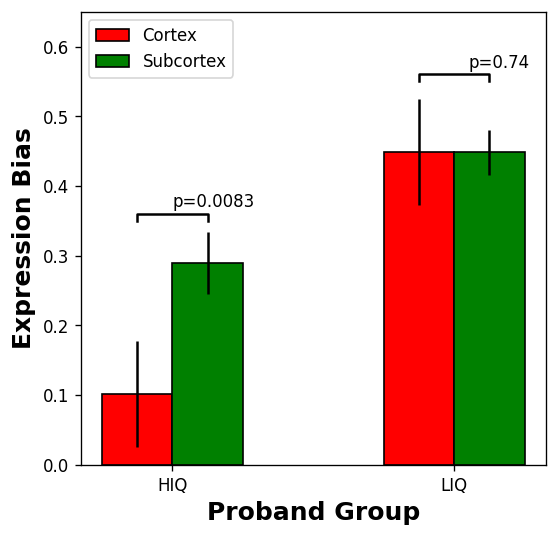

In [473]:
fig, ax = plt.subplots(dpi=120, figsize=(5,5))
X = np.arange(2)
ax.bar(X - 0.125, data[0], yerr=error1, color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.125, data[1], yerr=error2, color='green', width=0.25, label="Subcortex", edgecolor ='black')

props = {'connectionstyle':'bar','arrowstyle':'-',\
             'shrinkA':20,'shrinkB':20,'linewidth':2}

lx = 0 -0.125
rx = 0.25-0.125
y=0.35
barh=0.01
barx = [lx, lx, rx, rx]
bary = [y, y+barh, y+barh, y]
mid = ((lx+rx)/2, y+barh)
ax.plot(barx, bary, c='black')
ax.annotate("p=0.0083", xy=(0, 0.37), zorder=5)

lx = 1-0.125
rx = 1.25-0.125
y=0.55
barh=0.01
barx = [lx, lx, rx, rx]
bary = [y, y+barh, y+barh, y]
mid = ((lx+rx)/2, y+barh)
ax.plot(barx, bary, c='black')
ax.annotate("p=0.74", xy=(1.05, 0.570), zorder=6)


plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['HIQ', 'LIQ'])
ax.set_ylim(0,0.65)
plt.legend(loc="upper left")
#pdf.savefig( fig )

In [246]:
data2 = []
for group in ["HIQ", "LIQ"]:
    tmp = []
    for Narrow in CIR_REGIONS:
        tmp.append(np.median(REG_Layer1[Narrow][group]))
    data2.append(tmp)
data2 = np.array(data2)
#data2 = data.transpose()
color_map = {"HIQ":"blue", 
             "LIQ":"red"}

In [484]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Olfactory_areas']

In [485]:
CIR_REGIONS_Dict = {}
for i in range(len(CIR_REGIONS)):
    CIR_REGIONS_Dict[CIR_REGIONS[i]] = []
for _str in Circuit_STRs:
    for i in range(len(CIR_REGIONS)):
        if str2reg[_str] == CIR_REGIONS[i]:
            CIR_REGIONS_Dict[CIR_REGIONS[i]].append(_str)
            break

In [497]:
HighIQ_dat = []
LowIQ_dat = []
HighIQ_err = []
LowIQ_err = []
for REG in CIR_REGIONS:
    xx = GetBootsDist(HIQ_DFs, CIR_REGIONS_Dict[REG])
    HighIQ_err.append(np.std(xx))
    xx = GetBootsDist(LIQ_DFs, CIR_REGIONS_Dict[REG])
    LowIQ_err.append(np.std(xx))
    HighIQ_dat.append(GetBiasDat(HIQ_Spec, CIR_REGIONS_Dict[REG]))
    LowIQ_dat.append(GetBiasDat(LIQ_Spec, CIR_REGIONS_Dict[REG]))

In [498]:
HighIQ_dat

[0.09290182326190509,
 0.22921323612628408,
 0.16691617042574622,
 0.29588334066993677,
 0.36494081805902584,
 0.2801282587451911,
 0.35398355146107185]

In [499]:
LowIQ_dat

[0.44619893635789043,
 0.4835474945544611,
 0.4749557611227018,
 0.3637438175971526,
 0.4479812511689557,
 0.4446676672448387,
 0.42609199897921446]

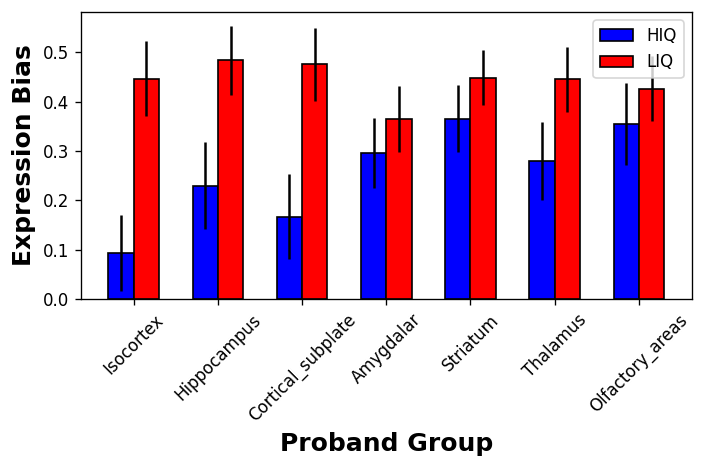

In [506]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))

ax.bar(X - 0.15, HighIQ_dat, yerr=HighIQ_err, color=color_map["HIQ"], width=0.3, label="HIQ", 
       edgecolor ='black')
ax.bar(X + 0.15, LowIQ_dat, yerr=LowIQ_err, color=color_map["LIQ"], width=0.3, label="LIQ", 
   edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.tight_layout()
#pdf.savefig( fig )

In [ ]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))
for i, g in enumerate(["HIQ", "LIQ"]):
    ax.bar(X -0.3 + 0.2 * i, data2[i], color=color_map[g], width=0.2, label=g, 
           edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.tight_layout()
pdf.savefig( fig )

In [248]:
pdf.close()

In [170]:
REG_Layer1 = {}
REG_Layer2 = {"Cortex":{}, "Subcortex":{}}
REG_Layer2["Cortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
REG_Layer2["Subcortex"] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
for STR in Circuit_STRs:
    REG = str2reg[STR]
    if REG not in REG_Layer1:
        REG_Layer1[REG] = {"HIQ_M":[], "HIQ_F":[], "LIQ_M":[], "LIQ_F":[]}
    REG_Layer1[REG]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer1[REG]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])
    
    if REG in Isocortex:
        Broder = "Cortex"
    else:
        Broder = "Subcortex"
    REG_Layer2[Broder]['HIQ_M'].append(HIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['HIQ_F'].append(HIQ_F_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_M'].append(LIQ_M_Spec.loc[STR, "EFFECT"])
    REG_Layer2[Broder]['LIQ_F'].append(LIQ_F_Spec.loc[STR, "EFFECT"])

In [171]:
data = []
for group in ["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]:
    tmp = []
    for Broder in ["Cortex", "Subcortex"]:
        tmp.append(np.mean(REG_Layer2[Broder][group]))
    data.append(tmp)
data = np.array(data)
data = data.transpose()

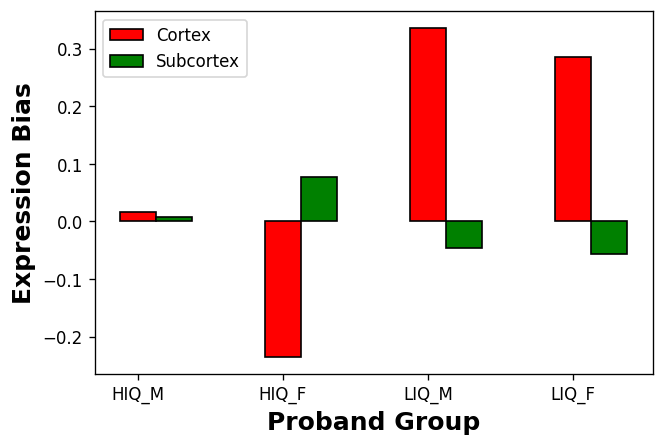

In [172]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(4)
ax.bar(X + 0.00, data[0], color='red', width=0.25, label="Cortex", edgecolor ='black')
ax.bar(X + 0.25, data[1], color='green', width=0.25, label="Subcortex", edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, ['HIQ_M', 'HIQ_F', 'LIQ_M', 'LIQ_F'])
 
plt.legend()
plt.show()

In [173]:
data2 = []
for group in ["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]:
    tmp = []
    for Narrow in CIR_REGIONS:
        tmp.append(np.median(REG_Layer1[Narrow][group]))
    data2.append(tmp)
data2 = np.array(data2)
#data2 = data.transpose()

In [174]:
color_map = {"HIQ_M":"lightsalmon", "HIQ_F":"greenyellow", 
             "LIQ_M":"red", "LIQ_F":"darkolivegreen"}

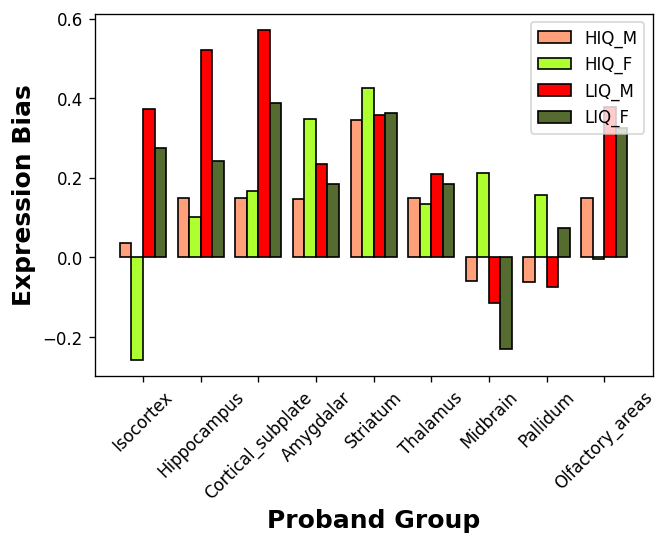

In [175]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))
for i, g in enumerate(["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]):
    ax.bar(X -0.3 + 0.2 * i, data2[i], color=color_map[g], width=0.2, label=g, 
           edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.show()

IndexError: list index out of range

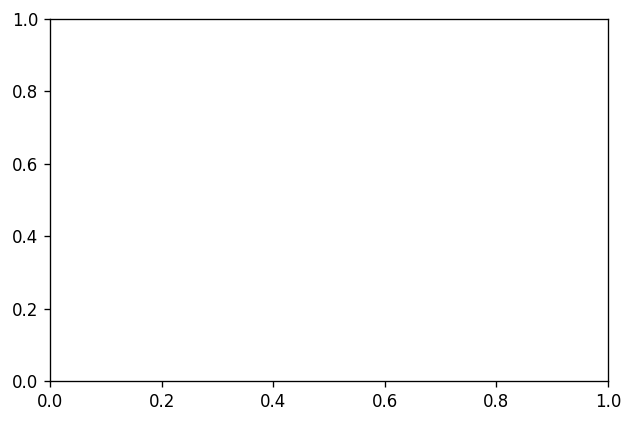

In [167]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))
for i, g in enumerate(["HIQ_M", "HIQ_F", "LIQ_M", "LIQ_F"]):
    ax.bar(X -0.3 + 0.2 * i, data2[i], color=color_map[g], width=0.2, label=g, 
           edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.show()

In [120]:
HighIQ_muts = ASD_Discov_Muts[ASD_Discov_Muts["IID"].isin(HighIQ)]
LowIQ_muts = ASD_Discov_Muts[ASD_Discov_Muts["IID"].isin(LowIQ)]
print(HighIQ_muts.shape, LowIQ_muts.shape)

(0, 44) (0, 44)


In [121]:
def CountMut(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["GeneEff"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            row["REVEL"] = row["REVEL"].split(";")[0]
            if row["REVEL"] != ".":
                if float(row["REVEL"]) > 0.5:
                    N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["HGNC"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["HGNC"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut(Muts)
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [122]:
HighIQ_muts_LGD_Mis = Filt_LGD_Mis(HighIQ_muts, Dmis=True)
LowIQ_muts_LGD_Mis = Filt_LGD_Mis(LowIQ_muts, Dmis=True)
print(HighIQ_muts_LGD_Mis.shape, LowIQ_muts_LGD_Mis.shape)

(0, 44) (0, 44)


In [123]:
# Select top ASD genes LGD/Dmis mutations
Spark_Meta = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/asd/spark_Meta_top_genes.xlsx")
HighConfGenes = Spark_Meta["HGNC"].values
HighIQ_Proband_HC = HighIQ_muts_LGD_Mis[HighIQ_muts_LGD_Mis["HGNC"].isin(HighConfGenes)]
HighIQ_Proband_HC.to_csv("dat/ASD_Proband_HC_HighIQ_LGD_Dmis.csv", index=False)
LowIQ_Proband_HC = LowIQ_muts_LGD_Mis[LowIQ_muts_LGD_Mis["HGNC"].isin(HighConfGenes)]
LowIQ_Proband_HC.to_csv("dat/ASD_Proband_HC_LowIQ_LGD_Dmis.csv", index=False)
print(HighIQ_Proband_HC.shape, LowIQ_Proband_HC.shape)

(0, 44) (0, 44)


In [124]:
Whole_Proband_IQ_Muts = HighIQ_Proband_HC.append(LowIQ_Proband_HC, ignore_index=True)

In [125]:
Probands_IQ_Mut_in_HC = Whole_Proband_IQ_Muts["IID"].values
Proband_HC_IQ = IQ_dat[IQ_dat["Phenotype_ID"].isin(Probands_IQ_Mut_in_HC)]

In [126]:
Whole_Proband_IQ_Muts.to_csv("dat/IQ_HC_muts.csv", index=False)
Proband_HC_IQ.to_csv("dat/IQ_HC_Phenotype.csv", index=False)

In [127]:
Proband_HC_IQ_perm = Proband_HC_IQ.copy(deep=True)
Proband_HC_IQ_perm["IQ"] = np.random.permutation(Proband_HC_IQ_perm["IQ"].values)

In [128]:
Proband_HC_IQ

,Sample,Phenotype_ID,Sex,Role,IQ,age_of_walking,Categorical_intellectual_disability_status,ASDp_carrier,ASDndd_carrier


In [129]:
Proband_HC_IQ_perm

,Sample,Phenotype_ID,Sex,Role,IQ,age_of_walking,Categorical_intellectual_disability_status,ASDp_carrier,ASDndd_carrier


## bias for two IQ group

In [67]:
HighIQ_gene2MutN = Mut2GeneDF(HighIQ_Proband_HC, 0.347, 0.194)
Agg_Match = pd.read_csv("dat/Final_Spark_Meta.Matches.csv", index_col="GENE")
HighIQ_Spec = AvgSTRZ_Weighted(ExpZscoreMat, HighIQ_gene2MutN, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/HighIQ_spec.bias.csv")

In [68]:
LowIQ_gene2MutN = Mut2GeneDF(LowIQ_Proband_HC, 0.347, 0.194)
LowIQ_Spec = AvgSTRZ_Weighted(ExpZscoreMat, LowIQ_gene2MutN, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/LowIQ_spec.bias.csv")

In [69]:
HighIQ_Spec = HighIQ_Spec.set_index("STR")
LowIQ_Spec = LowIQ_Spec.set_index("STR")

## STR bias for circuit STRs

In [184]:
Circuit_STRs = pd.read_csv("dat/Circuit_GN_42.csv")["STR"].values

In [185]:
len(Circuit_STRs)

43

In [569]:
HighIQ_Spec = pd.read_csv("dat/bias2/ASD.HIQ_spec.bias.csv", index_col="STR")
LowIQ_Spec = pd.read_csv("dat/bias2/ASD.LIQ_spec.bias.csv", index_col="STR")

In [570]:
str2reg = STR2Region()
IQ_Phenotype_dat = []
for STR in Circuit_STRs:
    Region = str2reg[STR]
    A_effect = HighIQ_Spec.loc[STR, "EFFECT"]
    B_effect = LowIQ_Spec.loc[STR, "EFFECT"]
    A_rank = HighIQ_Spec.loc[STR, "Rank"]
    B_rank = LowIQ_Spec.loc[STR, "Rank"]
    BiasDiff = B_effect - A_effect
    RankDiff = B_rank - A_rank
    IQ_Phenotype_dat.append([STR, Region, A_effect, B_effect, 
                             A_rank, B_rank, BiasDiff, RankDiff])
IQ_PhenotypeDF = pd.DataFrame(IQ_Phenotype_dat, columns=["STR", "REG", "HighIQ Bias", 
            "LowIQ Bias", "HighIQ Rank", "LowIQ Rank", "Bias Diff (low-high)", "Rank Diff"])
IQ_PhenotypeDF.to_csv("dat/IQ_Bias_Diff.csv", index=False)

In [571]:
writer = pd.ExcelWriter('dat/IQ_Bias.xlsx', engine='xlsxwriter')
IQ_PhenotypeDF.to_excel(writer, sheet_name='IQ_Bias_42_Circuits')
HighIQ_Spec.to_excel(writer, sheet_name='HighIQ_Spec')
LowIQ_Spec.to_excel(writer, sheet_name='LowIQ_Spec')
writer.save()

## XXXXX

In [50]:
adj_mat = pd.read_csv(ConnFil, index_col=0)
g = LoadConnectome2(adj_mat) # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")
#str2reg = STR2Region()
#str2reg_df = pd.read_csv(MajorBrainDivisions, delimiter="\t")

In [60]:
EdgeWeightsDict = {}
topNs = list(range(200, 10, -5))
ASD_Conn_Z, ASD_Cohe_Z, ASD_Conn_P, ASD_Cohe_P, ASD_Conn_E, ASD_Cohe_E = [],[],[],[],[],[]
Sib_Conn_Z, Sib_Cohe_Z, Sib_Conn_P, Sib_Cohe_P, Sib_Conn_E, Sib_Cohe_E = [],[],[],[],[],[]
for topN in topNs:
    Permuted_ASD_cohe = []
    Permuted_ASD_conn = []
    Permuted_Sib_cohe = []
    Permuted_Sib_conn = []
    for i in range(1000):
        adj_mat_perm = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
        g_perm = LoadConnectome2(adj_mat_perm)
        asd_cohe, asd_conn = ScoreSTRSet(g_perm, HighIQ_Spec.head(topN).index.values, EdgeWeightsDict)
        sib_cohe, sib_conn = ScoreSTRSet(g_perm, LowIQ_Spec.head(topN).index.values, EdgeWeightsDict)
        Permuted_ASD_cohe.append(asd_cohe)
        Permuted_ASD_conn.append(asd_conn)
        Permuted_Sib_cohe.append(sib_cohe)
        Permuted_Sib_conn.append(sib_conn)
    asd_cohe, asd_conn = ScoreSTRSet(g, HighIQ_Spec.head(topN).index.values, EdgeWeightsDict)
    sib_cohe, sib_conn = ScoreSTRSet(g, LowIQ_Spec.head(topN).index.values, EdgeWeightsDict)
    
    asd_z_conn, asd_p_conn = GetPermutationP(Permuted_ASD_conn, asd_conn)
    asd_z_cohe, asd_p_cohe = GetPermutationP(Permuted_ASD_cohe, asd_cohe)
    effect_conn = asd_conn/np.mean(Permuted_ASD_conn)
    effect_cohe = asd_cohe/np.mean(Permuted_ASD_cohe)
    ASD_Conn_Z.append(asd_z_conn); ASD_Cohe_Z.append(asd_z_cohe)
    ASD_Conn_P.append(asd_p_conn); ASD_Cohe_P.append(asd_p_cohe)
    ASD_Conn_E.append(effect_conn); ASD_Cohe_E.append(effect_cohe)
    
    sib_z_conn, sib_p_conn = GetPermutationP(Permuted_Sib_conn, sib_conn)
    sib_z_cohe, sib_p_cohe = GetPermutationP(Permuted_Sib_cohe, sib_cohe)
    effect_conn = sib_conn/np.mean(Permuted_Sib_conn)
    effect_cohe = sib_cohe/np.mean(Permuted_Sib_cohe)
    Sib_Conn_Z.append(sib_z_conn); Sib_Cohe_Z.append(sib_z_cohe)
    Sib_Conn_P.append(sib_p_conn); Sib_Cohe_P.append(sib_p_cohe)
    Sib_Conn_E.append(effect_conn); Sib_Cohe_E.append(effect_cohe)

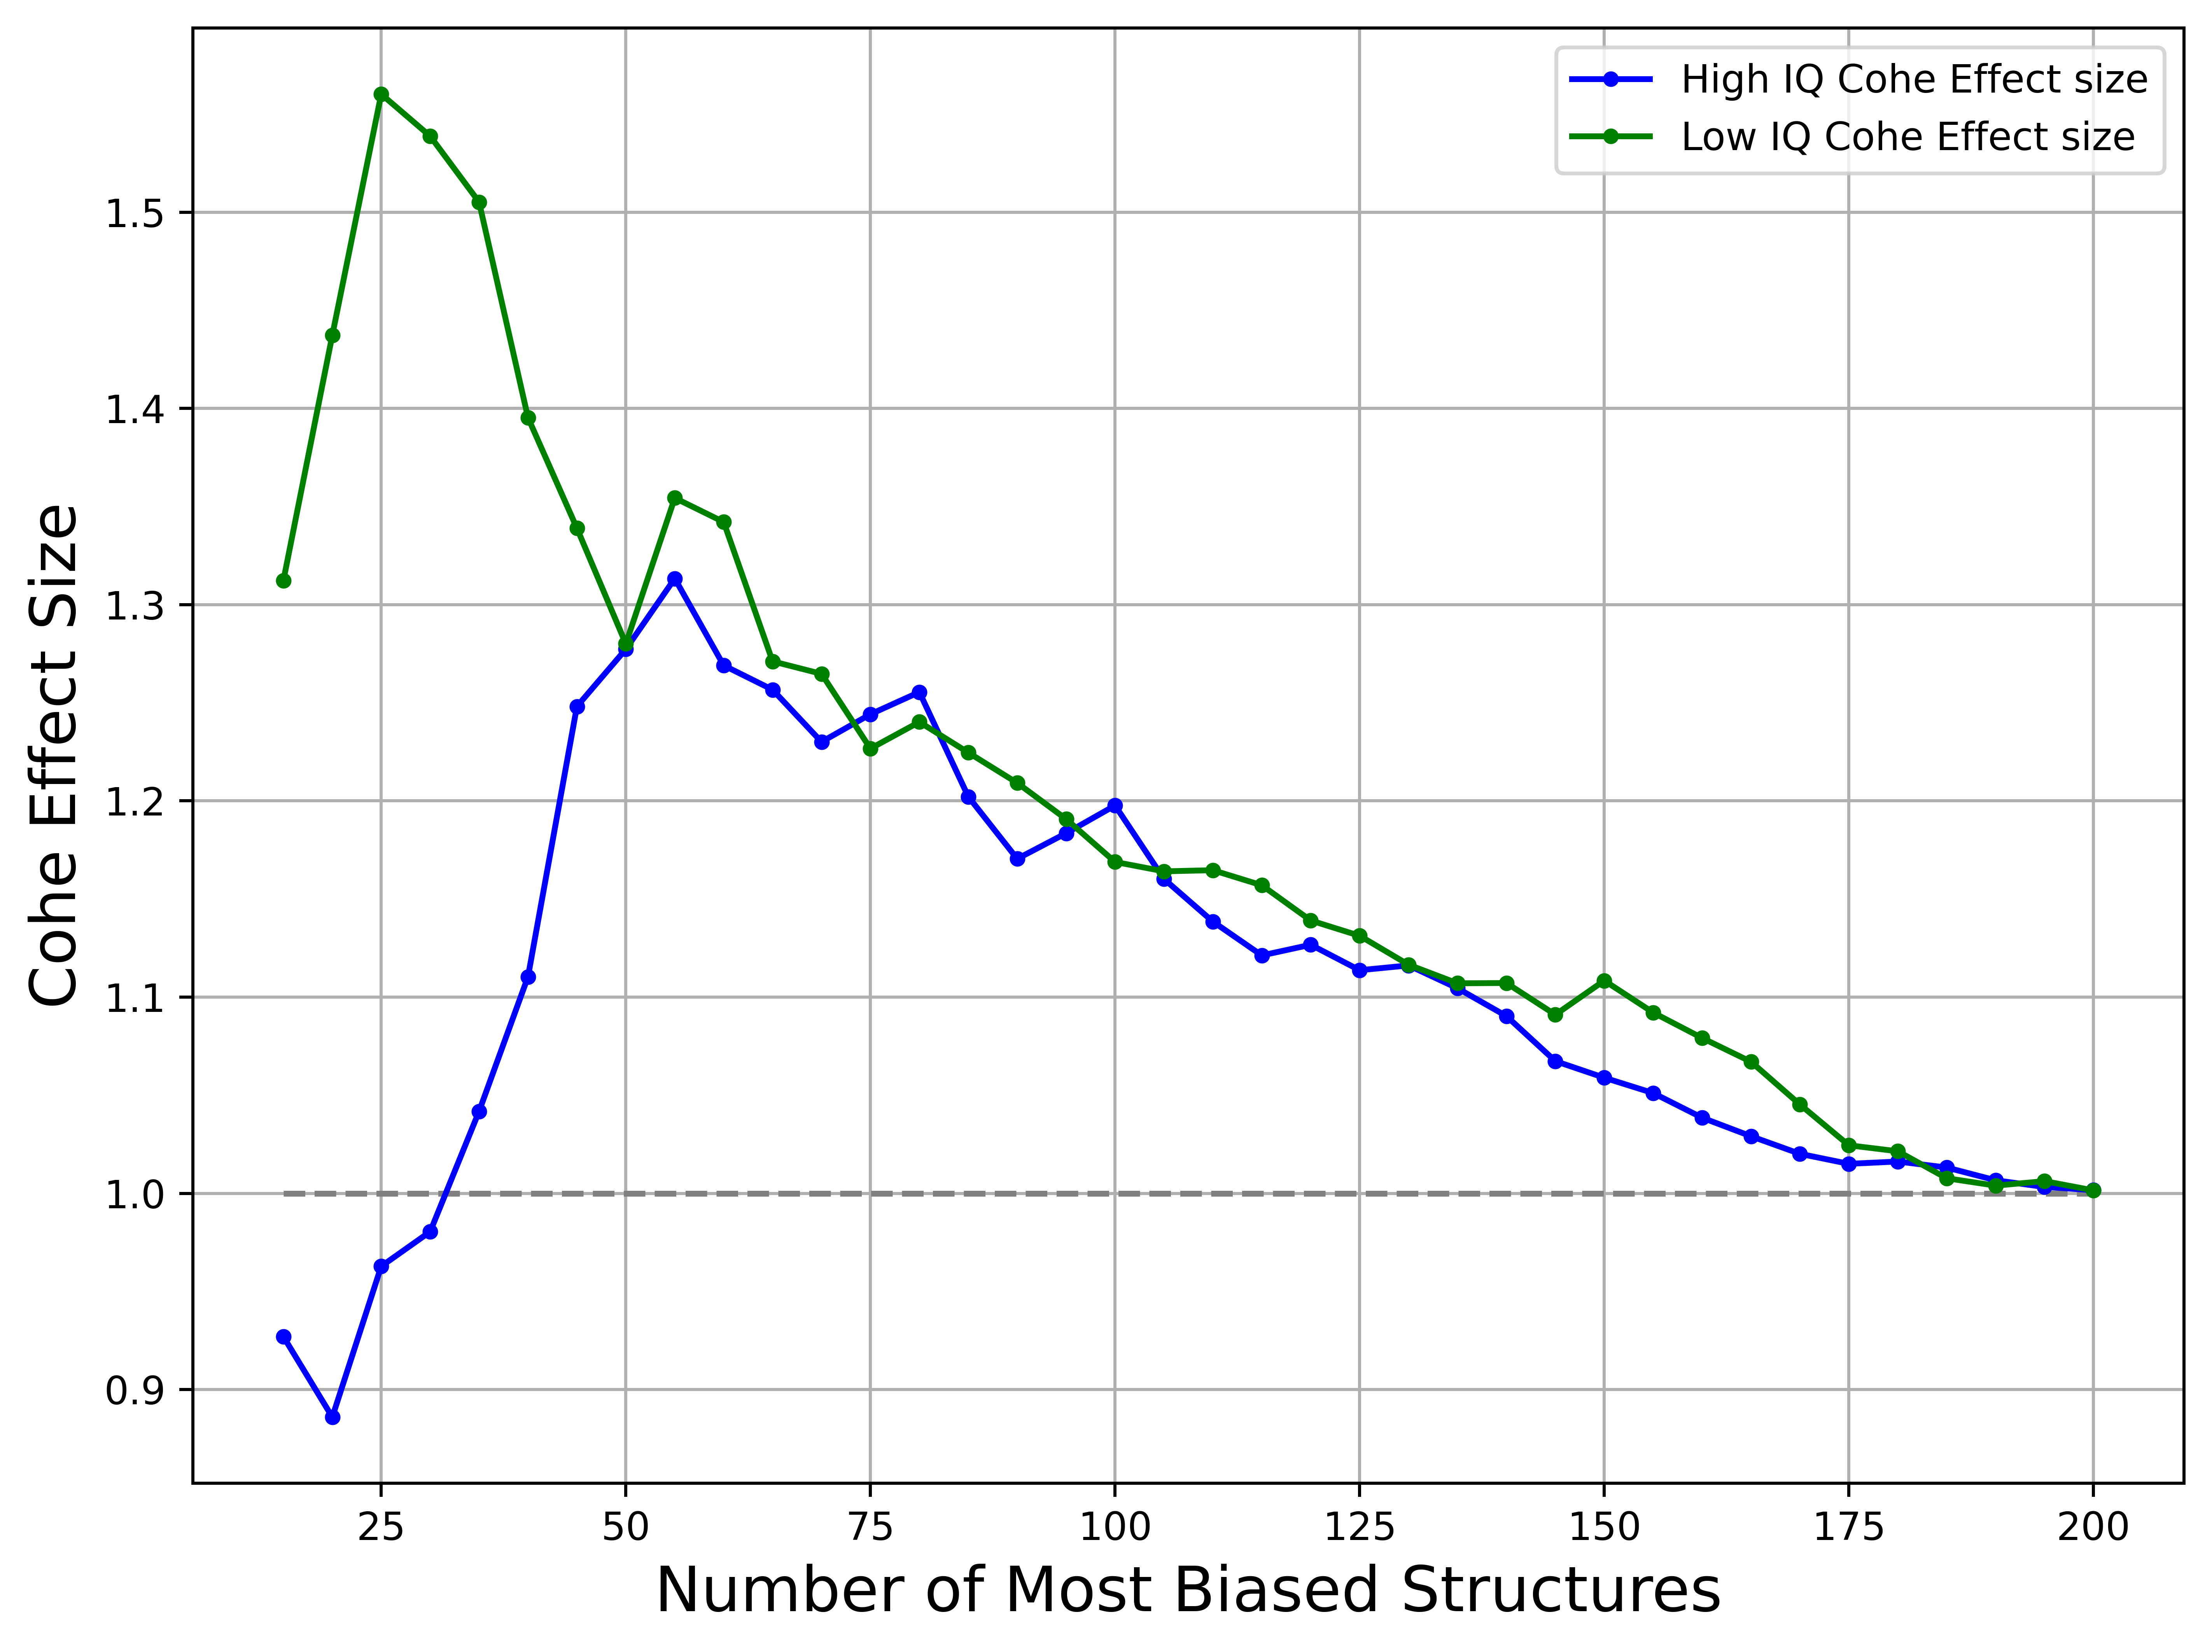

In [62]:
ASD_Conn_P = np.array(ASD_Conn_P)
fig, ax = plt.subplots(dpi=720, figsize=(8,6))

ax.plot(topNs, ASD_Cohe_E, label="High IQ Cohe Effect size", marker=".", color="blue")
ax.plot(topNs, Sib_Cohe_E, label="Low IQ Cohe Effect size", marker=".", color="green")

ax.hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
ax.grid(True)
ax.legend()
ax.set_ylabel("Cohe Effect Size",fontsize=16)
ax.set_xlabel("Number of Most Biased Structures",fontsize=16)


plt.tight_layout()

In [54]:
LowIQ_Spec.head(26).index.values

array(['Field_CA1', 'Dentate_gyrus', 'Field_CA2',
       'Lateral_amygdalar_nucleus', 'Prelimbic_area', 'Infralimbic_area',
       'Field_CA3', 'Lateral_posterior_nucleus_of_the_thalamus',
       'Subiculum_dorsal_part', 'Dorsal_peduncular_area', 'Claustrum',
       'Subiculum_ventral_part', 'Nucleus_of_reuniens',
       'Orbital_area_lateral_part', 'Anteromedial_visual_area',
       'Lateral_septal_nucleus_ventral_part', 'Nucleus_accumbens',
       'Anterior_pretectal_nucleus', 'Orbital_area_medial_part',
       'Mediodorsal_nucleus_of_thalamus',
       'Endopiriform_nucleus_dorsal_part',
       'Submedial_nucleus_of_the_thalamus',
       'Orbital_area_ventrolateral_part', 'Rhomboid_nucleus',
       'Agranular_insular_area_posterior_part',
       'Anterior_cingulate_area_dorsal_part'], dtype=object)

In [55]:
HighIQ_Spec.head(50).index.values

array(['Accessory_olfactory_bulb', 'Intercalated_amygdalar_nucleus',
       'Anterior_olfactory_nucleus',
       'Lateral_septal_nucleus_ventral_part',
       'Anterior_pretectal_nucleus', 'Dentate_gyrus',
       'Basomedial_amygdalar_nucleus', 'Mediodorsal_nucleus_of_thalamus',
       'Central_amygdalar_nucleus', 'Parafascicular_nucleus',
       'Parataenial_nucleus', 'Orbital_area_lateral_part',
       'Lateral_posterior_nucleus_of_the_thalamus',
       'Nucleus_of_the_posterior_commissure',
       'Nucleus_of_the_optic_tract',
       'Subparafascicular_nucleus_magnocellular_part', 'Parasubiculum',
       'Lateral_septal_nucleus_rostral_rostroventral_part',
       'Dorsomedial_nucleus_of_the_hypothalamus', 'Field_CA3',
       'Submedial_nucleus_of_the_thalamus',
       'Superior_central_nucleus_raphe', 'Subparafascicular_area',
       'Dorsal_peduncular_area', 'Posterior_complex_of_the_thalamus',
       'Endopiriform_nucleus_dorsal_part', 'Nucleus_of_reuniens',
       'Bed_nuclei_of_

In [56]:
HighIQ_Spec.head(50)

,EFFECT,REGION,Rank
STR,,,
Accessory_olfactory_bulb,0.427930,Olfactory_areas,1
Intercalated_amygdalar_nucleus,0.412990,Striatum,2
Anterior_olfactory_nucleus,0.406311,Olfactory_areas,3
Lateral_septal_nucleus_ventral_part,0.395143,Striatum,4
Anterior_pretectal_nucleus,0.381859,Midbrain,5
Dentate_gyrus,0.364890,Hippocampal_region,6
Basomedial_amygdalar_nucleus,0.349336,Cortical_subplate,7
Mediodorsal_nucleus_of_thalamus,0.346189,Thalamus,8
Central_amygdalar_nucleus,0.342902,Striatum,9


In [64]:
LowIQ_Spec.head(55)

,EFFECT,REGION,Rank
STR,,,
Field_CA1,0.624907,Hippocampal_region,1
Dentate_gyrus,0.610407,Hippocampal_region,2
Field_CA2,0.550272,Hippocampal_region,3
Lateral_amygdalar_nucleus,0.509946,Cortical_subplate,4
Prelimbic_area,0.504669,Isocortex,5
Infralimbic_area,0.474459,Isocortex,6
Field_CA3,0.471555,Hippocampal_region,7
Lateral_posterior_nucleus_of_the_thalamus,0.443449,Thalamus,8
Subiculum_dorsal_part,0.437142,Hippocampal_formation,9


## XXXX

In [188]:
# Load 1000 permutated expression bias
XXX = {"HighIQ":[], "LowIQ":[]}
for i in range(1, 10001):
    df1 = pd.read_csv("dat/IQ_permut/HighIQ_spec.bias.perm.{}.csv".format(i), index_col="STR")
    df2 = pd.read_csv("dat/IQ_permut/LowIQ_spec.bias.perm.{}.csv".format(i), index_col="STR")
    XXX["HighIQ"].append(df1)
    XXX["LowIQ"].append(df2)

In [189]:
print(len(XXX["HighIQ"]))

10000


In [190]:
def hahahaha(STR, XXX):
    res = []
    for i in range(0, 10000):
        #print(i, len(XXX["HighIQ"]))
        df1 = XXX["HighIQ"][i]
        df2 = XXX["LowIQ"][i]
        effect_diff = df2.loc[STR, "EFFECT"] - df1.loc[STR, "EFFECT"]
        res.append(effect_diff)
    return np.array(res)

In [203]:
IQ_PhenotypeDF = IQ_PhenotypeDF.set_index("STR")

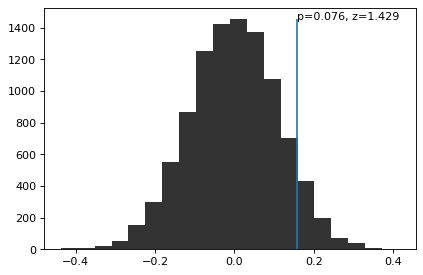

In [206]:
STR = "Nucleus_accumbens"
permut_diff = hahahaha(STR, XXX)
PlotPermutationP(permut_diff, IQ_PhenotypeDF.loc[STR, "Bias Diff (low-high)"])

In [191]:
DataDF_dat = []
for i, row in IQ_PhenotypeDF.iterrows():
    STR = row["STR"]
    REG = row["REG"]
    Diff = row["Bias Diff (low-high)"]
    HighIQ = row["HighIQ Bias"]
    LowIQ = row["LowIQ Bias"]
    permut_diff = hahahaha(STR, XXX)
    Z, P = GetPermutationP(permut_diff, Diff, gt=True)
    IQ_PhenotypeDF.loc[i, "Pvalue"] = P
    print("%s %.3f %.3f %.3f %.3e" % (STR, HighIQ, LowIQ, Diff, P))

Anterior_cingulate_area_dorsal_part 0.064 0.339 0.275 9.499e-03
Nucleus_accumbens 0.214 0.372 0.159 7.629e-02
Agranular_insular_area_posterior_part 0.131 0.348 0.216 2.060e-02
Agranular_insular_area_ventral_part 0.207 0.333 0.126 1.094e-01
Accessory_olfactory_bulb 0.428 0.309 -0.119 8.215e-01
Anterior_olfactory_nucleus 0.406 0.280 -0.126 8.140e-01
Basolateral_amygdalar_nucleus 0.051 0.312 0.261 1.870e-02
Bed_nuclei_of_the_stria_terminalis 0.218 0.274 0.056 2.913e-01
Central_amygdalar_nucleus 0.343 0.214 -0.129 8.910e-01
Claustrum 0.126 0.408 0.282 6.599e-03
Caudoputamen 0.111 0.241 0.130 1.327e-01
Dorsal_peduncular_area 0.232 0.432 0.201 4.050e-02
Endopiriform_nucleus_dorsal_part 0.228 0.365 0.137 1.238e-01
Frontal_pole_cerebral_cortex 0.119 0.253 0.133 1.543e-01
Gustatory_areas 0.080 0.303 0.223 2.120e-02
Intercalated_amygdalar_nucleus 0.413 0.280 -0.133 8.712e-01
Infralimbic_area 0.182 0.474 0.292 6.299e-03
Mediodorsal_nucleus_of_thalamus 0.346 0.365 0.019 4.490e-01
Primary_motor_are

In [192]:
# Let's make a plot
CIR_REGIONS = list(set(IQ_PhenotypeDF["REG"].values))

In [193]:
CIR_REGIONS = ['Isocortex', 'Hippocampal_formation', 'Hippocampal_region', 
    'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
 'Olfactory_areas']

In [194]:
#Color_dict = dict(zip(CIR_REGIONS, [""]))
color_dict = {"Amygdalar":"yellow","Isocortex":"skyblue", "Thalamus": "red", 
              "Striatum":"brown", "Olfactory_areas":"cyan", 
             "Hippocampal_formation":"green", "Hippocampal_region":"olive", 
              "Cortical_subplate":"purple", "Midbrain":"pink", "Pallidum":"Brown"}

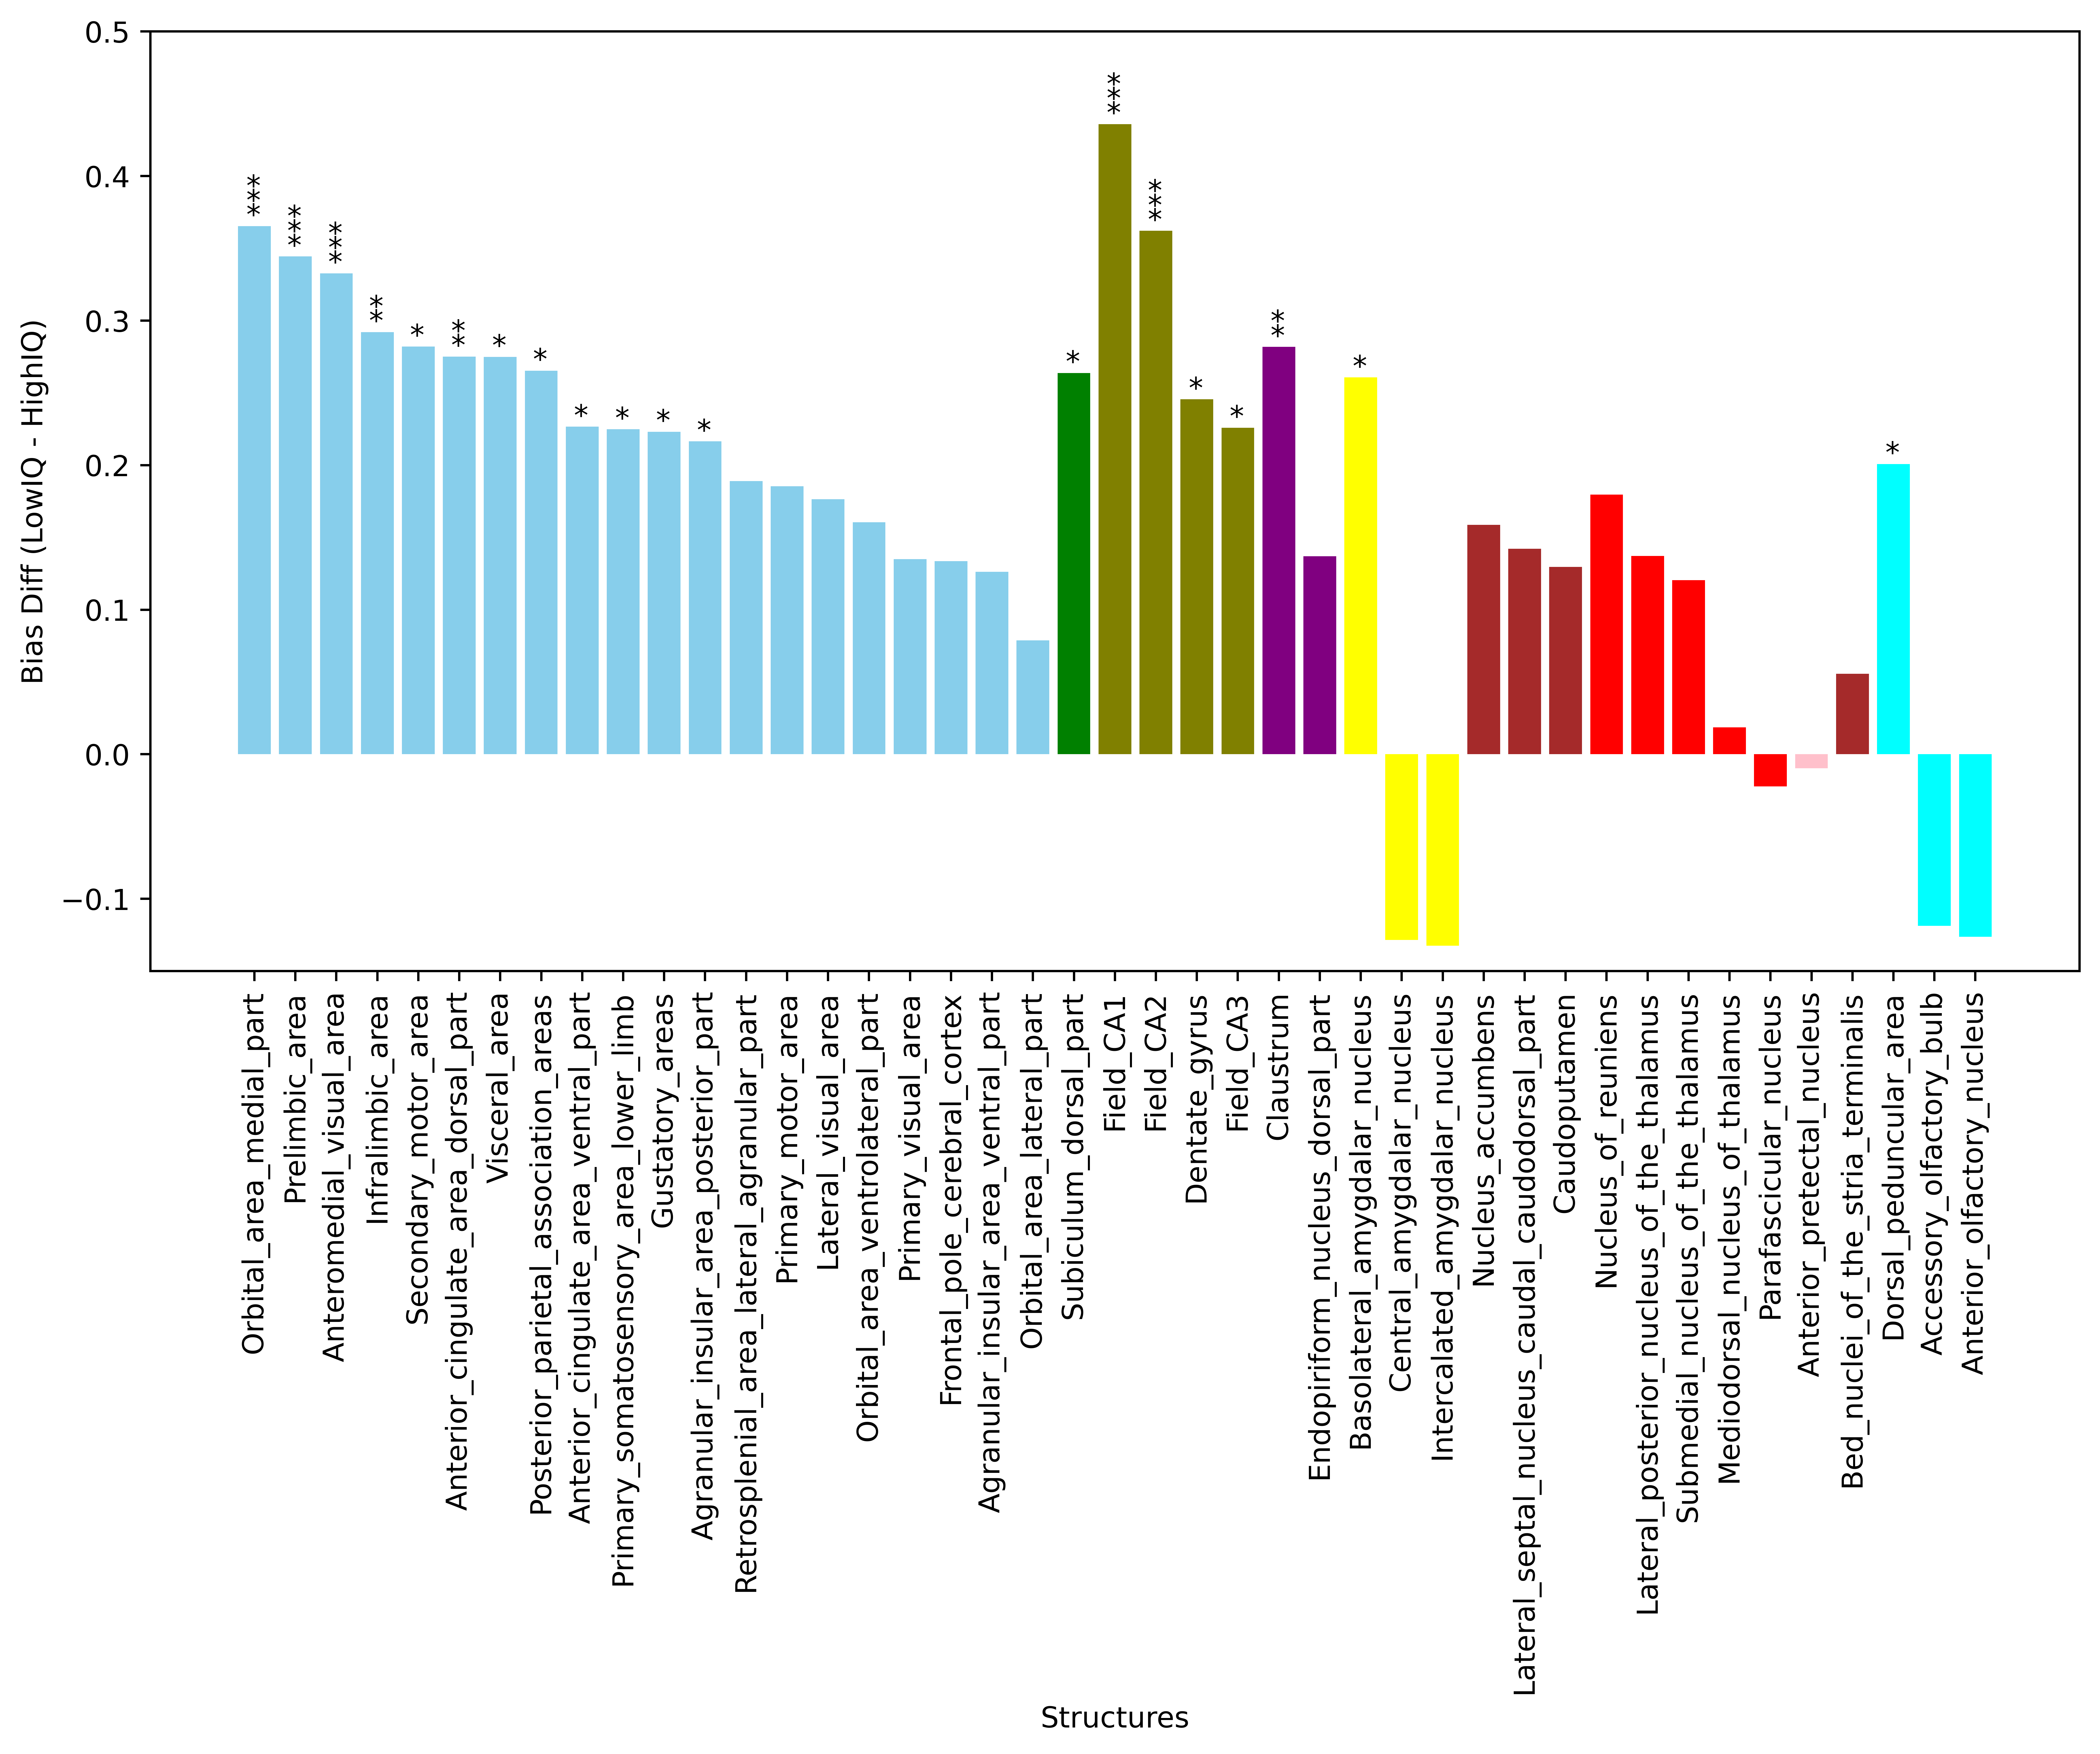

In [200]:
idx = 1
fig, ax = plt.subplots(dpi=720, figsize=(12,6))
STR_labels = []
for REG in CIR_REGIONS:
    #print(REG)
    xx = IQ_PhenotypeDF[IQ_PhenotypeDF["REG"]==REG]
    xx = xx.sort_values("Bias Diff (low-high)", ascending=False)
    for i, row in xx.iterrows():
        STR = row["STR"]
        REG = row["REG"]
        Diff = row["Bias Diff (low-high)"]
        Pvalue = row["Pvalue"]
        #print(STR, REG, Pvalue)
        ax.bar(idx, Diff, color=color_dict[REG])
        STR_labels.append(STR)
        if Pvalue < 0.05:
            ax.text(idx-0.20, Diff+0.001, s="*", color="black")
        if Pvalue < 0.01:
            ax.text(idx-0.20, Diff+0.011, s="*", color="black")
        if Pvalue < 0.005:
            ax.text(idx-0.20, Diff+0.021, s="*", color="black")
        idx += 1
ax.set_ylabel("Bias Diff (LowIQ - HighIQ)")
ax.set_xlabel("Structures")
ax.set_ylim(-0.15, 0.5)
ax.set_xticks(range(1, idx))
ax.set_xticklabels(STR_labels, rotation=90)
plt.show()

In [235]:
Cortex = ['Isocortex', 'Cortical_subplate']
Subcortex = ['Hippocampal_formation', 'Hippocampal_region', 'Amygdalar', 'Striatum', 
             'Thalamus', 'Midbrain', 'Pallidum', 'Olfactory_areas']

In [ ]:
['Isocortex', 'Hippocampal_formation', 'Hippocampal_region', 
    'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Midbrain', 'Pallidum',
 'Olfactory_areas']

## ID

In [210]:
ID_muts = pd.read_csv("../dat/genes/Denovo-v.1.5.intellectualDisability.variants.tsv", 
                     delimiter="\t")
ID_genes = pd.read_excel("../dat/genes/41593_2016_BFnn4352_MOESM22_ESM.xls")

In [213]:
ID_genelist = ID_genes[ID_genes["FDR.significant?"]<0.05]["gene.name"].values

In [218]:
ID_HC_muts = ID_muts[ID_muts["Gene"].isin(ID_genelist)]

In [232]:
def CountMut2(DF):
    N_LGD, N_mis, N_Dmis, N_syn = 0,0,0,0
    for i, row in DF.iterrows():
        GeneEff = row["FunctionClass"].split(";")[0]
        if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
            N_LGD += 1
        elif GeneEff == "missense":
            N_mis += 1
            if float(row["CaddScore"]) > 30:
                N_Dmis += 1
        elif GeneEff == "synonymous":
            N_syn += 1
    return N_LGD, N_mis, N_Dmis, N_syn

def Mut2GeneDF2(MutDF, w_LGD, w_Dmis):
    genes = np.array(list(set(MutDF["Gene"].values)))
    dat = []
    gene2MutN = {}
    for g in genes:
        try:
            Entrez = int(GeneSymbol2Entrez[g])
        except:
            Entrez = -1
            continue
        Muts = MutDF[MutDF["Gene"]==g]
        N_LGD, N_Mis, N_Dmis, N_Syn = CountMut2(Muts)
        gene2MutN[Entrez] = N_LGD * w_LGD + N_Dmis * w_Dmis
        #gene2MutN[Entrez] = N_LGD * w_LGD + N_Mis * w_Dmis
    return gene2MutN

In [233]:
ID_gene2MutN = Mut2GeneDF2(ID_HC_muts, 0.347, 0.194)
ID_Match = MakeMatchDF(ID_gene2MutN, N=1000)
ID_Spec = AvgSTRZ_Weighted(ExpZscoreMat, ID_gene2MutN, Match_DF=ID_Match,
                                 Method = 2, csv_fil = "dat/bias2/ID_spec.bias.csv")

In [234]:
RD_Agg_avgZ_RD = RegionDistributions(ID_Spec.set_index("STR"), show=True, topN=50)

Olfactory_areas 	 2 	 Dorsal_peduncular_area; Anterior_olfactory_nucleus
Amygdalar 	 5 	 Lateral_amygdalar_nucleus; Basolateral_amygdalar_nucleus; Posterior_amygdalar_nucleus; Intercalated_amygdalar_nucleus; Basomedial_amygdalar_nucleus
Thalamus 	 12 	 Nucleus_of_reuniens; Dorsal_part_of_the_lateral_geniculate_complex; Intermediodorsal_nucleus_of_the_thalamus; Central_medial_nucleus_of_the_thalamus; Submedial_nucleus_of_the_thalamus; Ventral_medial_nucleus_of_the_thalamus; Subparafascicular_area; Subparafascicular_nucleus_magnocellular_part; Mediodorsal_nucleus_of_thalamus; Central_lateral_nucleus_of_the_thalamus; Rhomboid_nucleus; Paraventricular_nucleus_of_the_thalamus
Midbrain 	 3 	 Nucleus_of_the_posterior_commissure; Interpeduncular_nucleus; Ventral_tegmental_area
Striatum 	 1 	 Septofimbrial_nucleus
Hippocampal_formation 	 1 	 Entorhinal_area_lateral_part
Medulla 	 6 	 Paragigantocellular_reticular_nucleus_dorsal_part; Hypoglossal_nucleus; Nucleus_prepositus; Magnocellular_reticu

## Indv Probands Hit

In [249]:
HighConfMuts.shape

(693, 44)

In [251]:
IQ_dat = IQ_dat.set_index("Phenotype_ID")

In [253]:
HighConfMuts_wIQ = HighConfMuts[HighConfMuts["IID"].isin(IQ_dat.index.values)]

In [255]:
for i, row in HighConfMuts_wIQ.iterrows():
    proband = row["IID"]
    IQ = IQ_dat.loc[proband, "IQ"]#[IQ_dat["IQ"]>70]["Phenotype_ID"].values
    HighConfMuts_wIQ.loc[i, "IQ"] = IQ

/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [305]:
IQ_seq, N_CirSTR_IQ_seq = [], [] 
N_Cortex_CirSTR_IQ_seq, N_Subcortex_CirSTR_IQ_seq = [], []
HighIQ_STR_Counts = {}
LowIQ_STR_Counts = {}
N_highIQ, N_lowIQ = 0,0
for STR in Circuit_STRs:
    HighIQ_STR_Counts[STR] = 0
    LowIQ_STR_Counts[STR] = 0
for i, var in HighConfMuts_wIQ.iterrows():
    IQ = var["IQ"]
    Gene = var["HGNC"]
    Entrez = int(GeneSymbol2Entrez.get(Gene, 0))
    if Entrez == 0 or Entrez not in allen_mouse_genes:
        continue
    Spec = IndvZ2.loc[Entrez, :].sort_values(ascending=False).head(50).index.values
    Spec_in_cir = list(set(Spec).intersection(Circuit_STRs))
    Spec_in_cir_cortex = [x for x in Spec_in_cir if str2reg[x] == 'Isocortex' ]
    Spec_in_cir_subcortex = [x for x in Spec_in_cir if str2reg[x] != 'Isocortex' ]
    IQ_seq.append(IQ)
    N_CirSTR_IQ_seq.append(len(Spec_in_cir))
    N_Cortex_CirSTR_IQ_seq.append(len(Spec_in_cir_cortex))
    N_Subcortex_CirSTR_IQ_seq.append(len(Spec_in_cir_subcortex))
    if IQ > 70:
        N_highIQ += 1
        for str_ in Spec_in_cir:
            HighIQ_STR_Counts[str_] += 1
    else:
        N_lowIQ += 1
        for str_ in Spec_in_cir:
            LowIQ_STR_Counts[str_] += 1
print(N_highIQ, N_lowIQ)

77 103


SpearmanrResult(correlation=-0.08946426964292771, pvalue=0.23235143500616637)
SpearmanrResult(correlation=-0.10476783294026476, pvalue=0.16161203348955436)


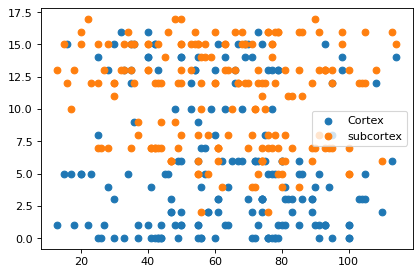

In [306]:
plt.scatter(IQ_seq, N_Cortex_CirSTR_IQ_seq, label="Cortex")
print(spearmanr(IQ_seq, N_Cortex_CirSTR_IQ_seq))
plt.scatter(IQ_seq, N_Subcortex_CirSTR_IQ_seq, label="subcortex")
print(spearmanr(IQ_seq, N_Subcortex_CirSTR_IQ_seq))
plt.legend()

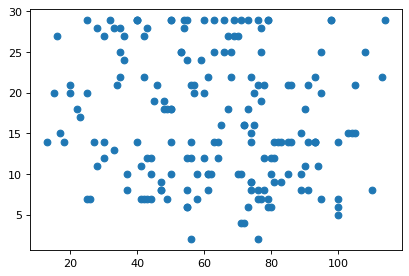

In [292]:
plt.scatter(IQ_seq, N_CirSTR_IQ_seq)

In [284]:
for STR in Circuit_STRs:
    print(STR, HighIQ_STR_Counts[STR], LowIQ_STR_Counts[STR])

Prelimbic_area 23 42
Lateral_amygdalar_nucleus 18 34
Orbital_area_lateral_part 37 57
Nucleus_accumbens 25 45
Dentate_gyrus 32 49
Infralimbic_area 15 41
Orbital_area_ventrolateral_part 20 48
Anterior_olfactory_nucleus 37 33
Anterior_pretectal_nucleus 26 31
Endopiriform_nucleus_dorsal_part 20 42
Claustrum 21 41
Dorsal_peduncular_area 17 39
Basomedial_amygdalar_nucleus 22 25
Field_CA1 21 41
Lateral_posterior_nucleus_of_the_thalamus 31 45
Field_CA3 20 35
Primary_somatosensory_area_lower_limb 23 40
Intercalated_amygdalar_nucleus 38 39
Field_CA2 21 40
Anteromedial_visual_area 17 42
Nucleus_of_reuniens 22 37
Caudoputamen 18 29
Lateral_septal_nucleus_ventral_part 44 40
Parafascicular_nucleus 23 38
Bed_nuclei_of_the_stria_terminalis 31 34
Subiculum_ventral_part 17 37
Endopiriform_nucleus_ventral_part 16 37
Retrosplenial_area_lateral_agranular_part 23 39
Submedial_nucleus_of_the_thalamus 18 33
Primary_visual_area 30 42
Anterior_cingulate_area_dorsal_part 15 38
Visceral_area 25 44
Agranular_insul

# RBS

(38620, 65)
Median 31.000000


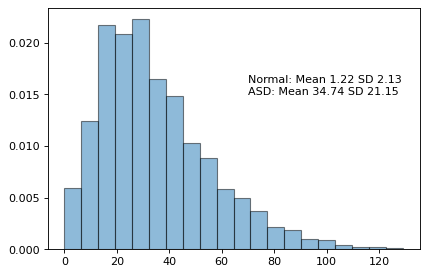

In [534]:
SparkRBSR = pd.read_csv("~/Work/ASD_Phenotype/SPARK_Collection_Version6/rbsr.csv")
SparkRBSR = SparkRBSR.dropna(subset=["total_final_score"])
print(SparkRBSR.shape)
#print(SparkRBSR.columns.values)
print("Median %f"%(np.median(SparkRBSR["total_final_score"].values)))
fig, ax = plt.subplots()
ax.hist(SparkRBSR["total_final_score"], bins=20, density=1, alpha=0.5, edgecolor='black')
ax.text(70, 0.015, s="Normal: Mean 1.22 SD 2.13\nASD: Mean %.2f SD %.2f"%
        (np.mean(SparkRBSR["total_final_score"].values), np.std(SparkRBSR["total_final_score"].values)))
plt.show()

In [556]:
HighRBS = SparkRBSR[SparkRBSR["total_final_score"] >= 31]
LowRBS = SparkRBSR[SparkRBSR["total_final_score"] < 31]
print(HighRBS.shape, LowRBS.shape)

# Select HC genes
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_HC = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
#Spark_Meta = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1e-3]
HighConfGenes = Spark_Meta_HC["HGNC"].values
HighConfMuts = ASD_Discov_Muts[ASD_Discov_Muts["HGNC"].isin(HighConfGenes)]
#HighConfMuts = ASD_Discov_Muts
HighConfMuts = Filt_LGD_Mis(HighConfMuts, Dmis=True)
#HighConfMuts = HighConfMuts[HighConfMuts["GeneEff"]!="missense"]

# Use All genes

HighRBS_Muts = HighConfMuts[HighConfMuts["IID"].isin(HighRBS["subject_sp_id"].values)]
LowRBS_Muts = HighConfMuts[HighConfMuts["IID"].isin(LowRBS["subject_sp_id"].values)]
print(HighRBS_Muts.shape, LowRBS_Muts.shape)

(19358, 65) (19262, 65)
(82, 44) (124, 44)


### Bias on sub-population

In [540]:
HRBS_GW = Mut2GeneDF(HighRBS_Muts, 0.347, 0.194) # Not use weights input
HRBS_Spec = AvgSTRZ_Weighted(ExpZscoreMat, HRBS_GW, Match_DF=Agg_Match, 
                                 Method = 2, csv_fil = "dat/bias2/ASD.HRBS_spec.bias.csv")

LRBS_GW = Mut2GeneDF(LowRBS_Muts, 0.347, 0.194)
LRBS_Spec = AvgSTRZ_Weighted(ExpZscoreMat, LRBS_GW, Match_DF=Agg_Match,
                                 Method = 2, csv_fil = "dat/bias2/ASD.LRBS_spec.bias.csv")

In [545]:
HRBS_Spec = HRBS_Spec.set_index("STR")
LRBS_Spec = LRBS_Spec.set_index("STR")

In [541]:
CIR_REGIONS = ['Isocortex', 'Hippocampus', 
     'Cortical_subplate', 'Amygdalar', 'Striatum', 'Thalamus', 'Olfactory_areas']
CIR_REGIONS_Dict = {}
for i in range(len(CIR_REGIONS)):
    CIR_REGIONS_Dict[CIR_REGIONS[i]] = []
for _str in Circuit_STRs:
    for i in range(len(CIR_REGIONS)):
        if str2reg[_str] == CIR_REGIONS[i]:
            CIR_REGIONS_Dict[CIR_REGIONS[i]].append(_str)
            break

In [546]:
HighRBS_dat = []
LowRBS_dat = []
#HighIQ_err = []
#LowIQ_err = []
for REG in CIR_REGIONS:
    #xx = GetBootsDist(HIQ_DFs, CIR_REGIONS_Dict[REG])
    #HighIQ_err.append(np.std(xx))
    #xx = GetBootsDist(LIQ_DFs, CIR_REGIONS_Dict[REG])
    #LowIQ_err.append(np.std(xx))
    HighRBS_dat.append(GetBiasDat(HRBS_Spec, CIR_REGIONS_Dict[REG]))
    LowRBS_dat.append(GetBiasDat(LRBS_Spec, CIR_REGIONS_Dict[REG]))

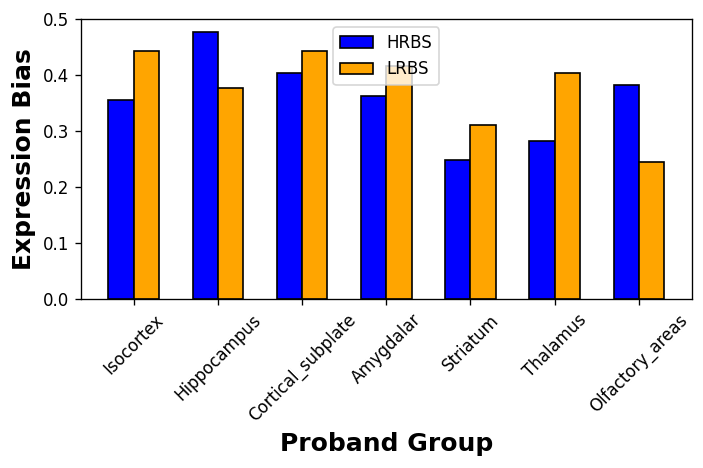

In [599]:
fig, ax = plt.subplots(dpi=120)
X = np.arange(len(CIR_REGIONS))

ax.bar(X - 0.15, HighRBS_dat, color='blue', width=0.3, label="HRBS", 
       edgecolor ='black')
ax.bar(X + 0.15, LowRBS_dat, color='orange', width=0.3, label="LRBS", 
   edgecolor ='black')

plt.xlabel('Proband Group', fontweight ='bold', fontsize = 15)
plt.ylabel('Expression Bias', fontweight ='bold', fontsize = 15)
plt.xticks(X, CIR_REGIONS, rotation=45)
 
plt.legend()
plt.tight_layout()
#pdf.savefig( fig )
plt.savefig("figs/Phenotype_RBS_STR_Bias.pdf")

In [551]:
RBS_Phenotype_dat = []
for STR in Circuit_STRs:
    Region = str2reg[STR]
    A_effect = HRBS_Spec.loc[STR, "EFFECT"]
    B_effect = LRBS_Spec.loc[STR, "EFFECT"]
    A_rank = HRBS_Spec.loc[STR, "Rank"]
    B_rank = LRBS_Spec.loc[STR, "Rank"]
    BiasDiff = B_effect - A_effect
    RankDiff = B_rank - A_rank
    RBS_Phenotype_dat.append([STR, Region, A_effect, B_effect, 
                             A_rank, B_rank, BiasDiff, RankDiff])
RBS_PhenotypeDF = pd.DataFrame(RBS_Phenotype_dat, columns=["STR", "REG", "HighRBS Bias", 
            "LowRBS Bias", "HighRBS Rank", "LowRBS Rank", "Bias Diff (low-high)", "Rank Diff"])
RBS_PhenotypeDF.to_csv("dat/RBS_Bias_Diff.csv", index=False)

In [552]:
writer = pd.ExcelWriter('dat/RBS_Bias.xlsx', engine='xlsxwriter')
RBS_PhenotypeDF.to_excel(writer, sheet_name='RBS_Bias_Circuits')
HRBS_Spec.to_excel(writer, sheet_name='HighIQ_Spec')
LRBS_Spec.to_excel(writer, sheet_name='LowIQ_Spec')
writer.save()

In [600]:
print(len( set(HRBS_Spec.head(50).index.values).intersection(
    set(LRBS_Spec.head(50).index.values)) ))

35


-0.06336648062342214 0.6619840342032234 0.022136854741896757 0.8787210618032604


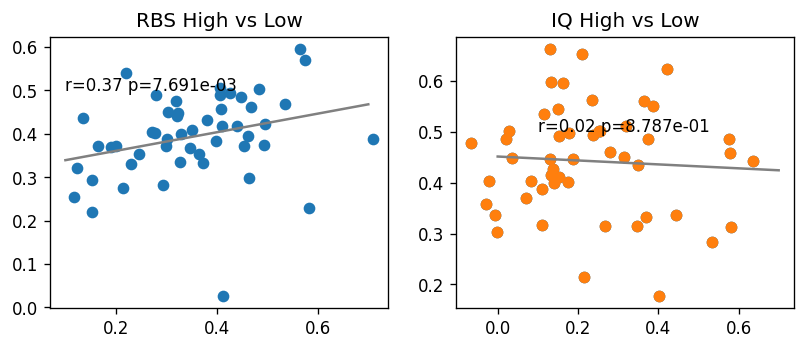

In [609]:
fig, (ax1, ax2) = plt.subplots(1,2, dpi=120, figsize=(8,3))
X = RBS_PhenotypeDF["HighRBS Bias"].values
Y = RBS_PhenotypeDF["LowRBS Bias"].values
lm = sm.OLS(Y,sm.add_constant(X)).fit()
X_plot = np.array([0.1, 0.7])
ax1.plot(X_plot, X_plot*lm.params[1] + lm.params[0], color="grey")
#plt.text(0.1, 0.5, s="coef=%.2f P=%.3e"%(lm.params[1], lm.pvalues[1]))
r, p = pearsonr(X,Y)
rho, p_rho = spearmanr(X,Y)
ax1.text(0.1, 0.5, s="r=%.2f p=%.3e"%(rho, p_rho))
ax1.scatter(X,Y)
ax1.set_title("RBS High vs Low")

X = IQ_PhenotypeDF["HighIQ Bias"].values
Y = IQ_PhenotypeDF["LowIQ Bias"].values
lm = sm.OLS(Y,sm.add_constant(X)).fit()
X_plot = np.array([0.0, 0.7])
ax2.plot(X_plot, X_plot*lm.params[1] + lm.params[0], color="grey")
r, p = pearsonr(X,Y)

rho, p_rho = spearmanr(X,Y)
ax2.text(0.1, 0.5, s="r=%.2f p=%.3e"%(rho, p_rho))
ax2.scatter(X,Y)
ax2.scatter(X,Y)
ax2.set_title("IQ High vs Low")
plt.savefig("figs/Phenotype_RBS_IQ_correlation.pdf")

In [608]:
print(len( set(HighIQ_Spec.head(50).index.values).intersection(
    set(LowIQ_Spec.head(50).index.values)) ))

19


In [606]:
HighIQ_Spec

,EFFECT,REGION,Rank
STR,,,
Anterior_pretectal_nucleus,0.636909,Midbrain,1
Accessory_olfactory_bulb,0.581818,Olfactory_areas,2
Anterior_olfactory_nucleus,0.578369,Olfactory_areas,3
Lateral_septal_nucleus_ventral_part,0.576520,Striatum,4
Intercalated_amygdalar_nucleus,0.534196,Amygdalar,5
...,...,...,...
Medullary_reticular_nucleus_ventral_part,-0.551383,Medulla,209
Primary_auditory_area,-0.563877,Isocortex,210
Magnocellular_reticular_nucleus,-0.589455,Medulla,211


In [607]:
LowIQ_Spec

,EFFECT,REGION,Rank
STR,,,
Lateral_amygdalar_nucleus,0.662807,Amygdalar,1
Prelimbic_area,0.653488,Isocortex,2
Dentate_gyrus,0.622575,Hippocampus,3
Infralimbic_area,0.597998,Isocortex,4
Field_CA1,0.596485,Hippocampus,5
...,...,...,...
Intermediate_reticular_nucleus,-0.830554,Medulla,209
Lateral_reticular_nucleus,-0.832421,Medulla,210
Paragigantocellular_reticular_nucleus_lateral_part,-0.848677,Medulla,211
